# Import

In [1]:
import sys
!{sys.executable} -m pip install numpy matplotlib scikit-learn imbalanced-learn seaborn lightgbm

In [2]:
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import IsolationForest, HistGradientBoostingClassifier, HistGradientBoostingRegressor, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, PredefinedSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import seaborn as sns
import lightgbm as lgb

# Fetch

In [3]:
def process_cell(data):
    if '\n' in data:
        data = data.replace('\n', '')
    return float(data)
    
def fetch_dataset(path):
    with open(path) as f:
        read_lines = f.readlines()
        y=[]
        X=[]
        for i in range(len(read_lines)):
            line = list(map(process_cell, read_lines[i].split(',')))
            X.append(line[1:])
            y.append(line[0])
        y = list(map(lambda x: int(x),y))
        return X,y

default_path = "./data/data.txt"
X, y = fetch_dataset(default_path)

# Split

In [4]:
train_len = 463715
X_train, y_train = np.array(X[:train_len]), np.array(y[:train_len])
X_test, y_test = np.array(X[train_len:]), np.array(y[train_len:])

# Analiza

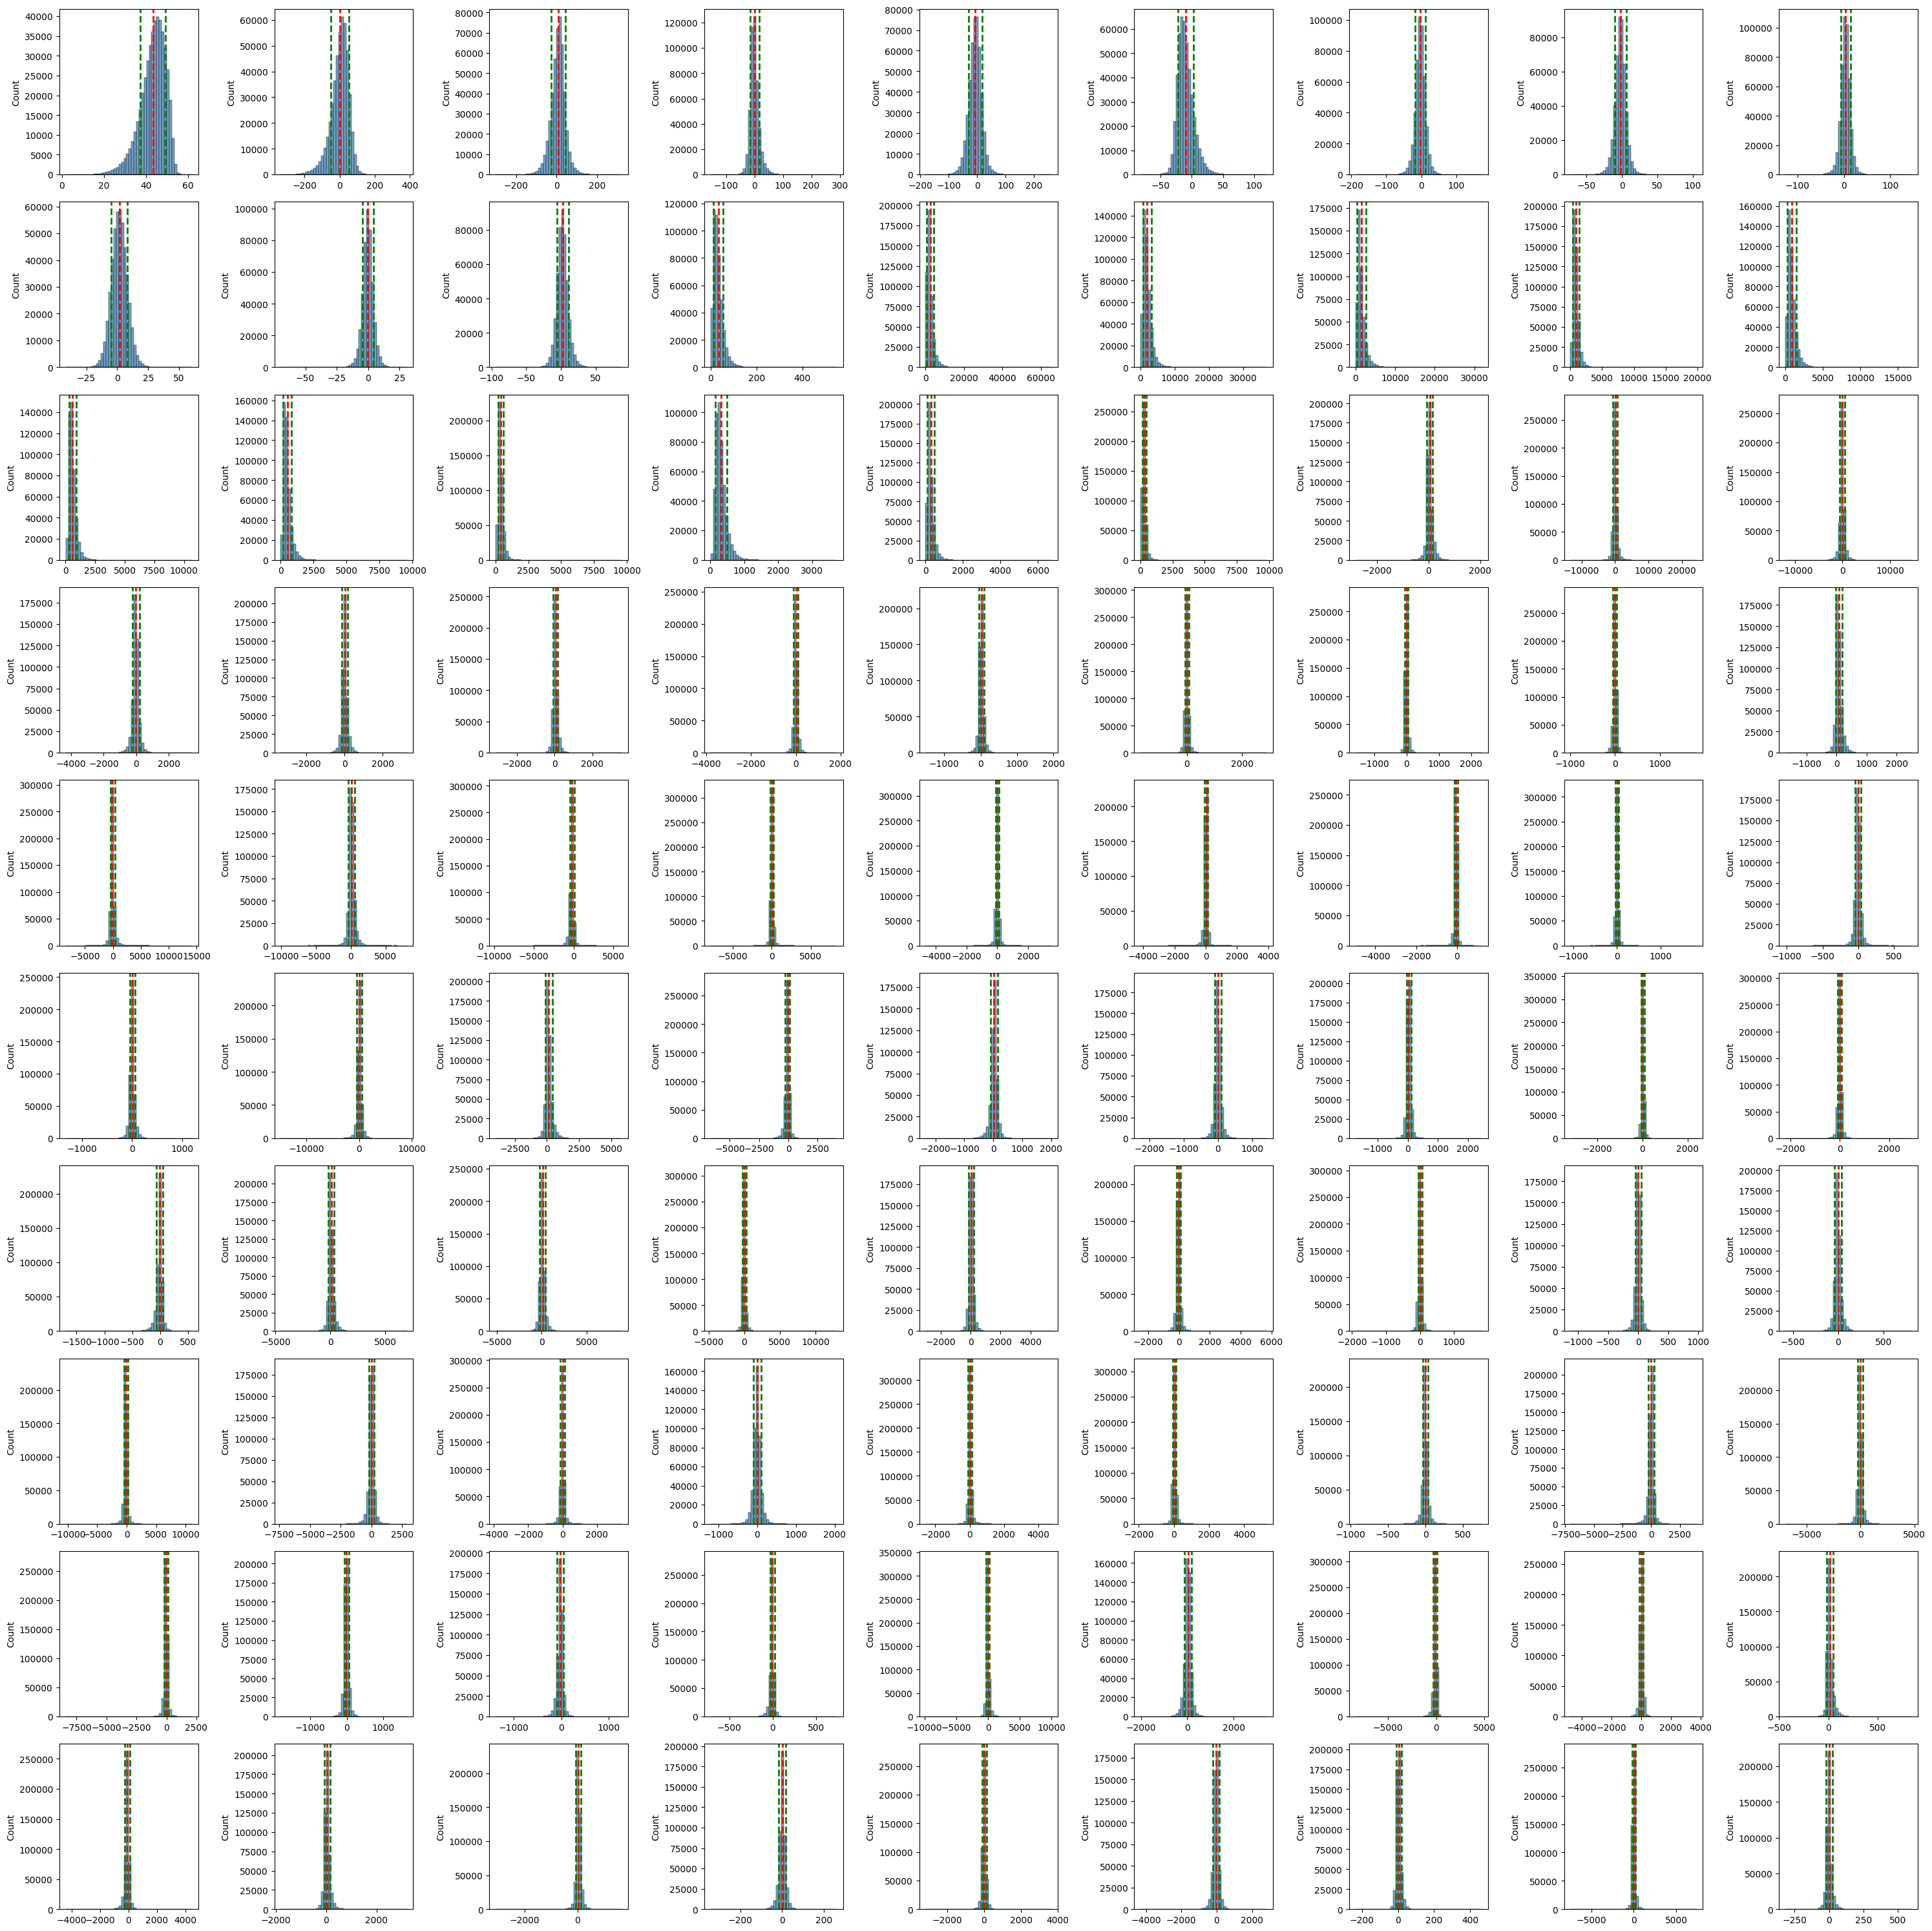

In [5]:
def plot_sub(data, axes, i, j, bins, color,title=None):
    m = np.mean(data)
    v = np.var(data)
    sns.histplot(data = data, bins = bins, ax = axes[i,j], color=color, legend=False)
    axes[i,j].axvline(m, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {m:.2f}')
    axes[i,j].axvline(m - np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'-1 SD')
    axes[i,j].axvline(m + np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'+1 SD')

    if not title is None:
        axes[i,j].set_title(title)

def plot_features(X):
    X_t = np.transpose(X)
    w = int(len(X_t)**0.5)
    h = len(X_t)//w
    if len(X_t)%w !=0:
        h+=1
    fig, axes = plt.subplots(h, w, figsize = (30,30))
    for i in range(h):
        for j in range(w):
            ind = i*w + j
            plot_sub(X_t[ind], axes, i, j, 50, 'steelblue')
    plt.tight_layout()
    plt.show()

plot_features(X_train)

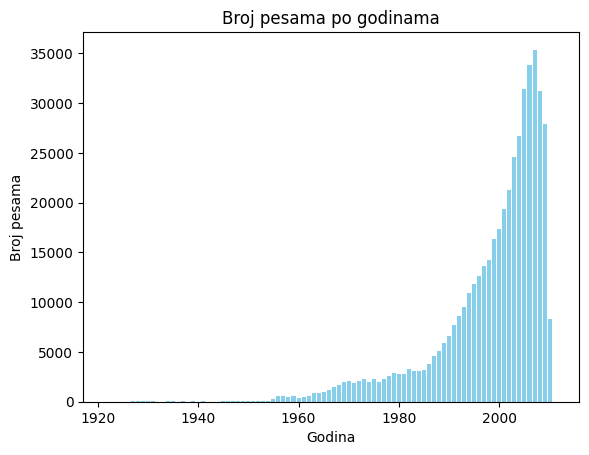

[1922 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936
 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950
 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011]
[    6     5     7    19    40    48    79    38    31    11     6    28
    24    22    25    19    35    14    31    21    13    14    27    29
    55    38    53    58    62    65   121   108   253   535   559   522
   544   398   521   581   867   850   996  1202  1517  1655  1986  2124
  1866  2078  2325  1983  2297  1957  2258  2597  2864  2794  2788  3284
  3083  3053  3211  3747  4608  5101  5944  6606  7751  8615  9562 10882
 11806 12669 13639 14245 16358 17354 19415 21291 24574 26680 31454 33824
 35375 31244 27907  8363     1]


In [6]:
unique_years, count_per_year = np.unique(y_train, return_counts=True)
plt.bar(unique_years, count_per_year, color='skyblue')
plt.xlabel('Godina')
plt.ylabel('Broj pesama')
plt.title('Broj pesama po godinama')
plt.show()
print(unique_years)
print(count_per_year)

In [7]:
year_map = {}
for i in range(len(unique_years)):
    year_map[unique_years[i]] = i

- Primecujemo da imamo samo 1 pesmu u 2011, koju mozemo da izbacimo
- Pored toga, imamo premalo pesama iz 20ih i 30ih

# Outlieri

**Kako imamo samo jednu pesmu iz 2011, izbacujemo je odmah**

In [8]:
indices = np.where(y_train==2011)[0]
y_train = np.delete(y_train,indices)
X_train = np.delete(X_train,indices,axis=0)

In [9]:
def get_map(y):
    rez = {}
    for i in range(len(y)):
        rez[y[i]] = i
    return rez
    
def remove_outliers(X, y, thresh):
    is_forest = IsolationForest(n_jobs=-1)
    is_forest.fit(X)
    preds = is_forest.predict(X)

    outlier_vals = []
    outlier_inds = []
    for i in range(len(preds)):
        #Outlier
        if preds[i]==-1:
            outlier_vals.append(y[i])
            outlier_inds.append(i)

    y_vals, y_counts = np.unique(y, return_counts=True)
    y_map = get_map(y_vals)

    out_vals, out_counts = np.unique(outlier_vals, return_counts=True)
    out_map = get_map(out_vals)

    to_remove_ind = []

    k = list(zip(outlier_inds, outlier_vals))
    for (i, val) in k:
        total_y = y_counts[y_map[val]]
        total_y_to_remove = out_counts[out_map[val]]
        if total_y_to_remove < (total_y//thresh):
            to_remove_ind.append(i)

    return np.delete(X,to_remove_ind,axis=0), np.delete(y,to_remove_ind)


In [10]:
X_train_no_out, y_train_no_out = remove_outliers(X_train,y_train,10)

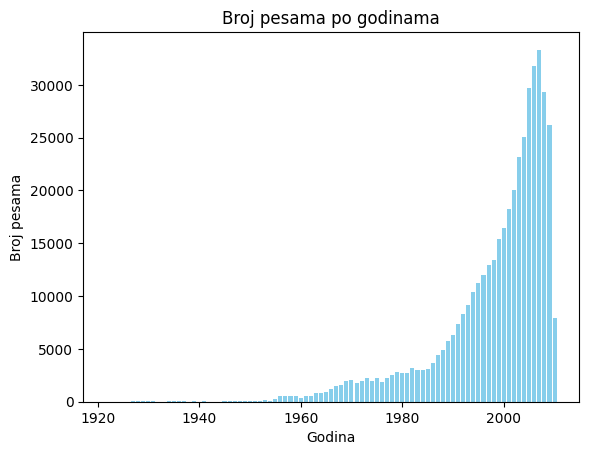

[1922 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936
 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950
 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010]
[    6     5     7    19    40    48    79    36    31    11     6    28
    24    22    25    19    35    14    31    21    13    14    27    29
    55    38    53    58    62    65   121   105   253   535   508   500
   532   387   503   569   853   839   959  1175  1482  1611  1928  2080
  1816  2000  2258  1929  2241  1911  2223  2533  2786  2723  2717  3212
  3001  2956  3116  3622  4448  4900  5759  6352  7403  8288  9158 10394
 11251 11992 12951 13441 15448 16402 18271 20003 23134 25090 29736 31788
 33320 29362 26193  7891]


In [11]:
u, c = np.unique(y_train_no_out, return_counts=True)
plt.bar(u, c, color='skyblue')
plt.xlabel('Godina')
plt.ylabel('Broj pesama')
plt.title('Broj pesama po godinama')
plt.show()
print(u)
print(c)

# Sampling

In [12]:
def augment_smote(X, y, smote_dict):
    over = SMOTE(sampling_strategy=smote_dict, k_neighbors=4)
    return over.fit_resample(X, y)

def get_smote_dict(years, year_count, ratio_maj_min):
    max_count = year_count[np.argmax(year_count)]
    min_count = max_count // ratio_maj_min
    res = {}
    for i in range(len(years)):
        res[years[i]] = max(year_count[i], min_count)
    return res
    
unique_years, count_per_year = np.unique(y_train_no_out, return_counts=True)   
smote_dict = get_smote_dict(unique_years,count_per_year,4)
X_train_smote, y_train_smote = augment_smote(X_train_no_out,y_train_no_out,smote_dict)

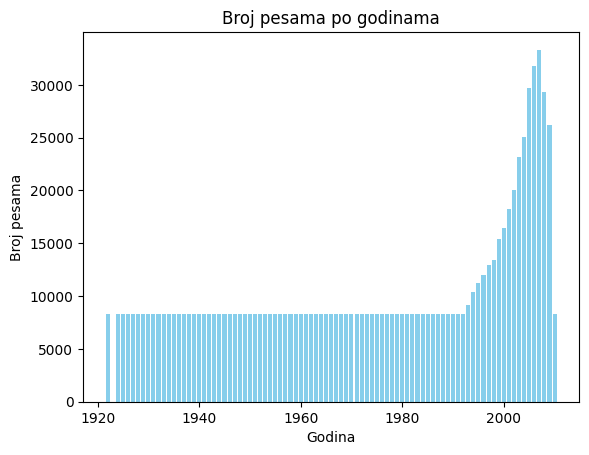

[1922 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936
 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950
 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010]
[ 8330  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330
  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330
  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330
  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330
  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330
  8330  8330  8330  8330  8330  8330  8330  8330  8330  8330  9158 10394
 11251 11992 12951 13441 15448 16402 18271 20003 23134 25090 29736 31788
 33320 29362 26193  8330]


In [13]:
u, c = np.unique(y_train_smote, return_counts=True)
plt.bar(u, c, color='skyblue')
plt.xlabel('Godina')
plt.ylabel('Broj pesama')
plt.title('Broj pesama po godinama')
plt.show()
print(u)
print(c)

In [14]:
#X_train, y_train - podaci svi, bez 2011
#X_train_no_out, y_train_no_out - izbaceni outlieri
#X_train_smote, y_train_smote - izbaceni outlieri + oversample
#X_train_stand - no_outlier + oversample + standardized
#X_train_final, y_train_final - no_outlier + oversample + standardized + reduce_dim

# Transformacije

In [15]:
#Standardizacija
def transform_features(X):
    X_t = np.transpose(X)
    transforms = []
    for i in range(len(X_t)):
        pt = PowerTransformer(method='yeo-johnson', standardize=True)
        X_t[i] = pt.fit_transform(X_t[i].reshape(-1,1)).reshape(1,-1)
        transforms.append(pt)
    return np.transpose(X_t), transforms

def apply_transform(X, transforms):
    X_t = np.transpose(X)
    for i in range(len(X_t)):
        pt = transforms[i]
        X_t[i] = pt.fit_transform(X_t[i].reshape(-1,1)).reshape(1,-1)
    return np.transpose(X_t)

In [16]:
X_train_stand, transfroms = transform_features(X_train_smote) 

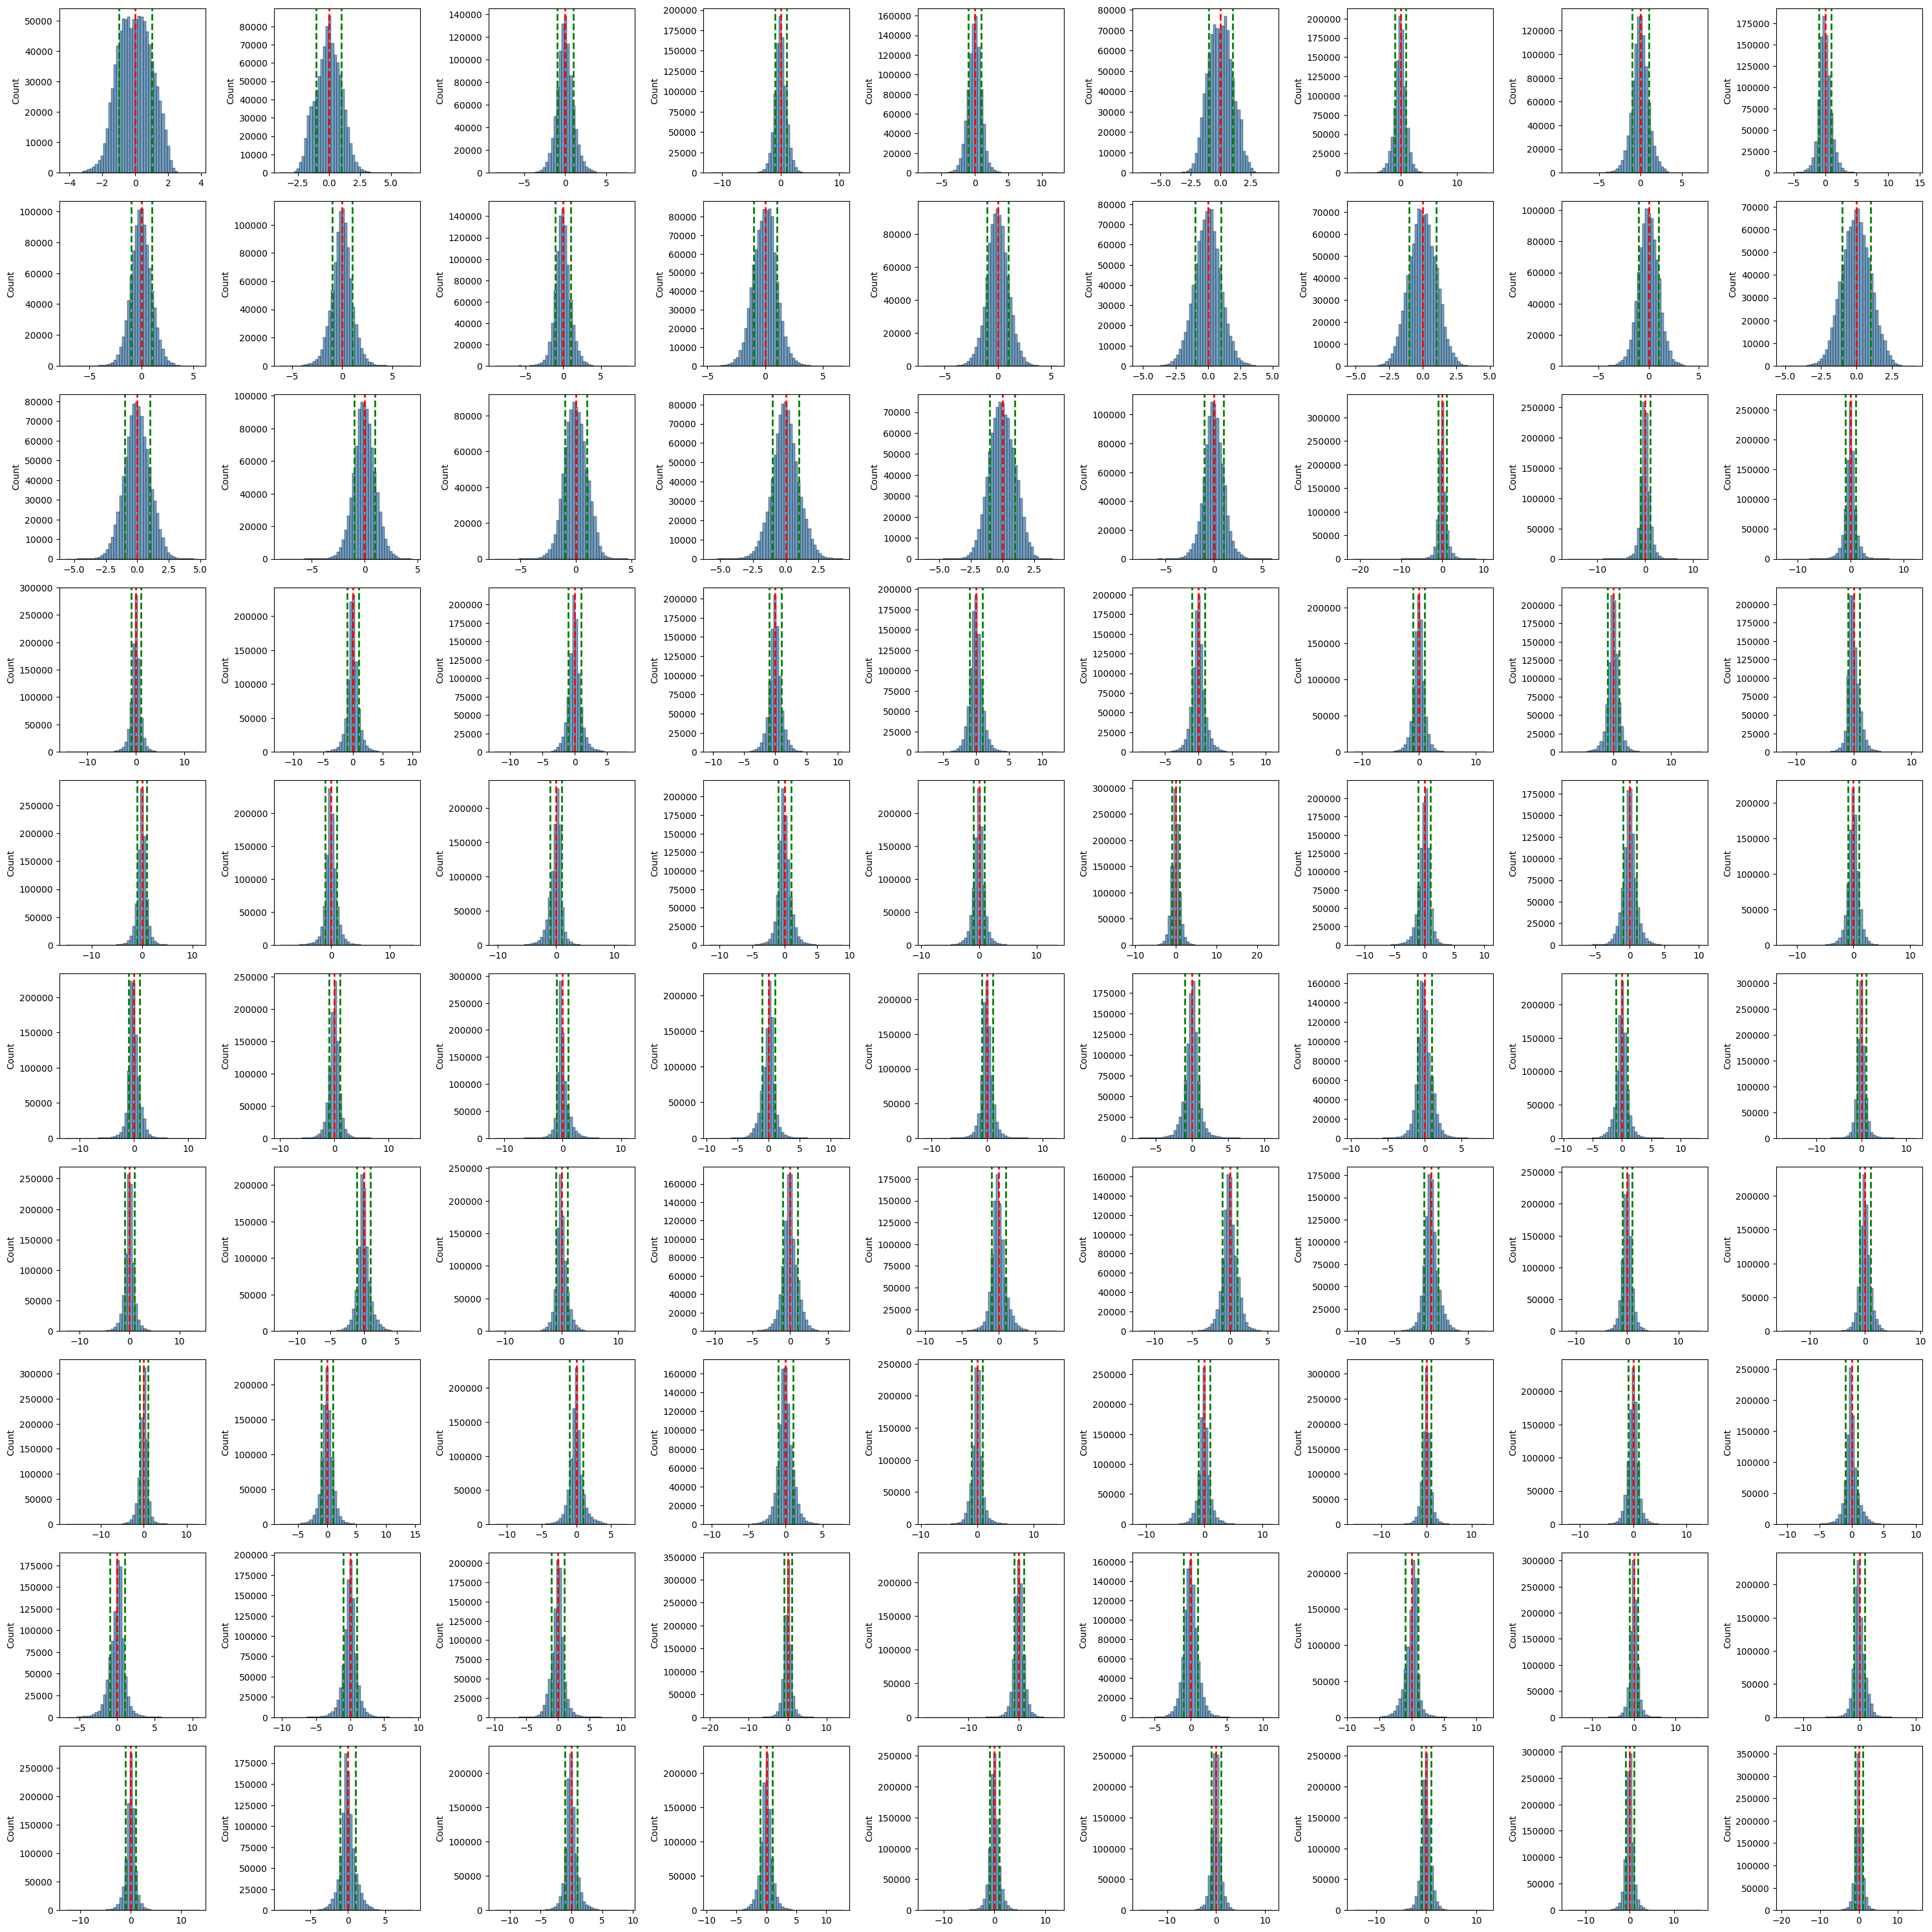

In [17]:
plot_features(X_train_stand)

In [18]:
def reduce_dim(X, total_var):
    pca = PCA(n_components = total_var)
    pca.fit(X)
    return pca.transform(X), pca

def apply_reduce_dim(X, dim_red):
    return dim_red.transform(X)

In [19]:
X_train_final, dim_red = reduce_dim(X_train_stand,0.98)
X_train_final = np.copy(X_train_stand)
y_train_final = np.copy(y_train_smote)

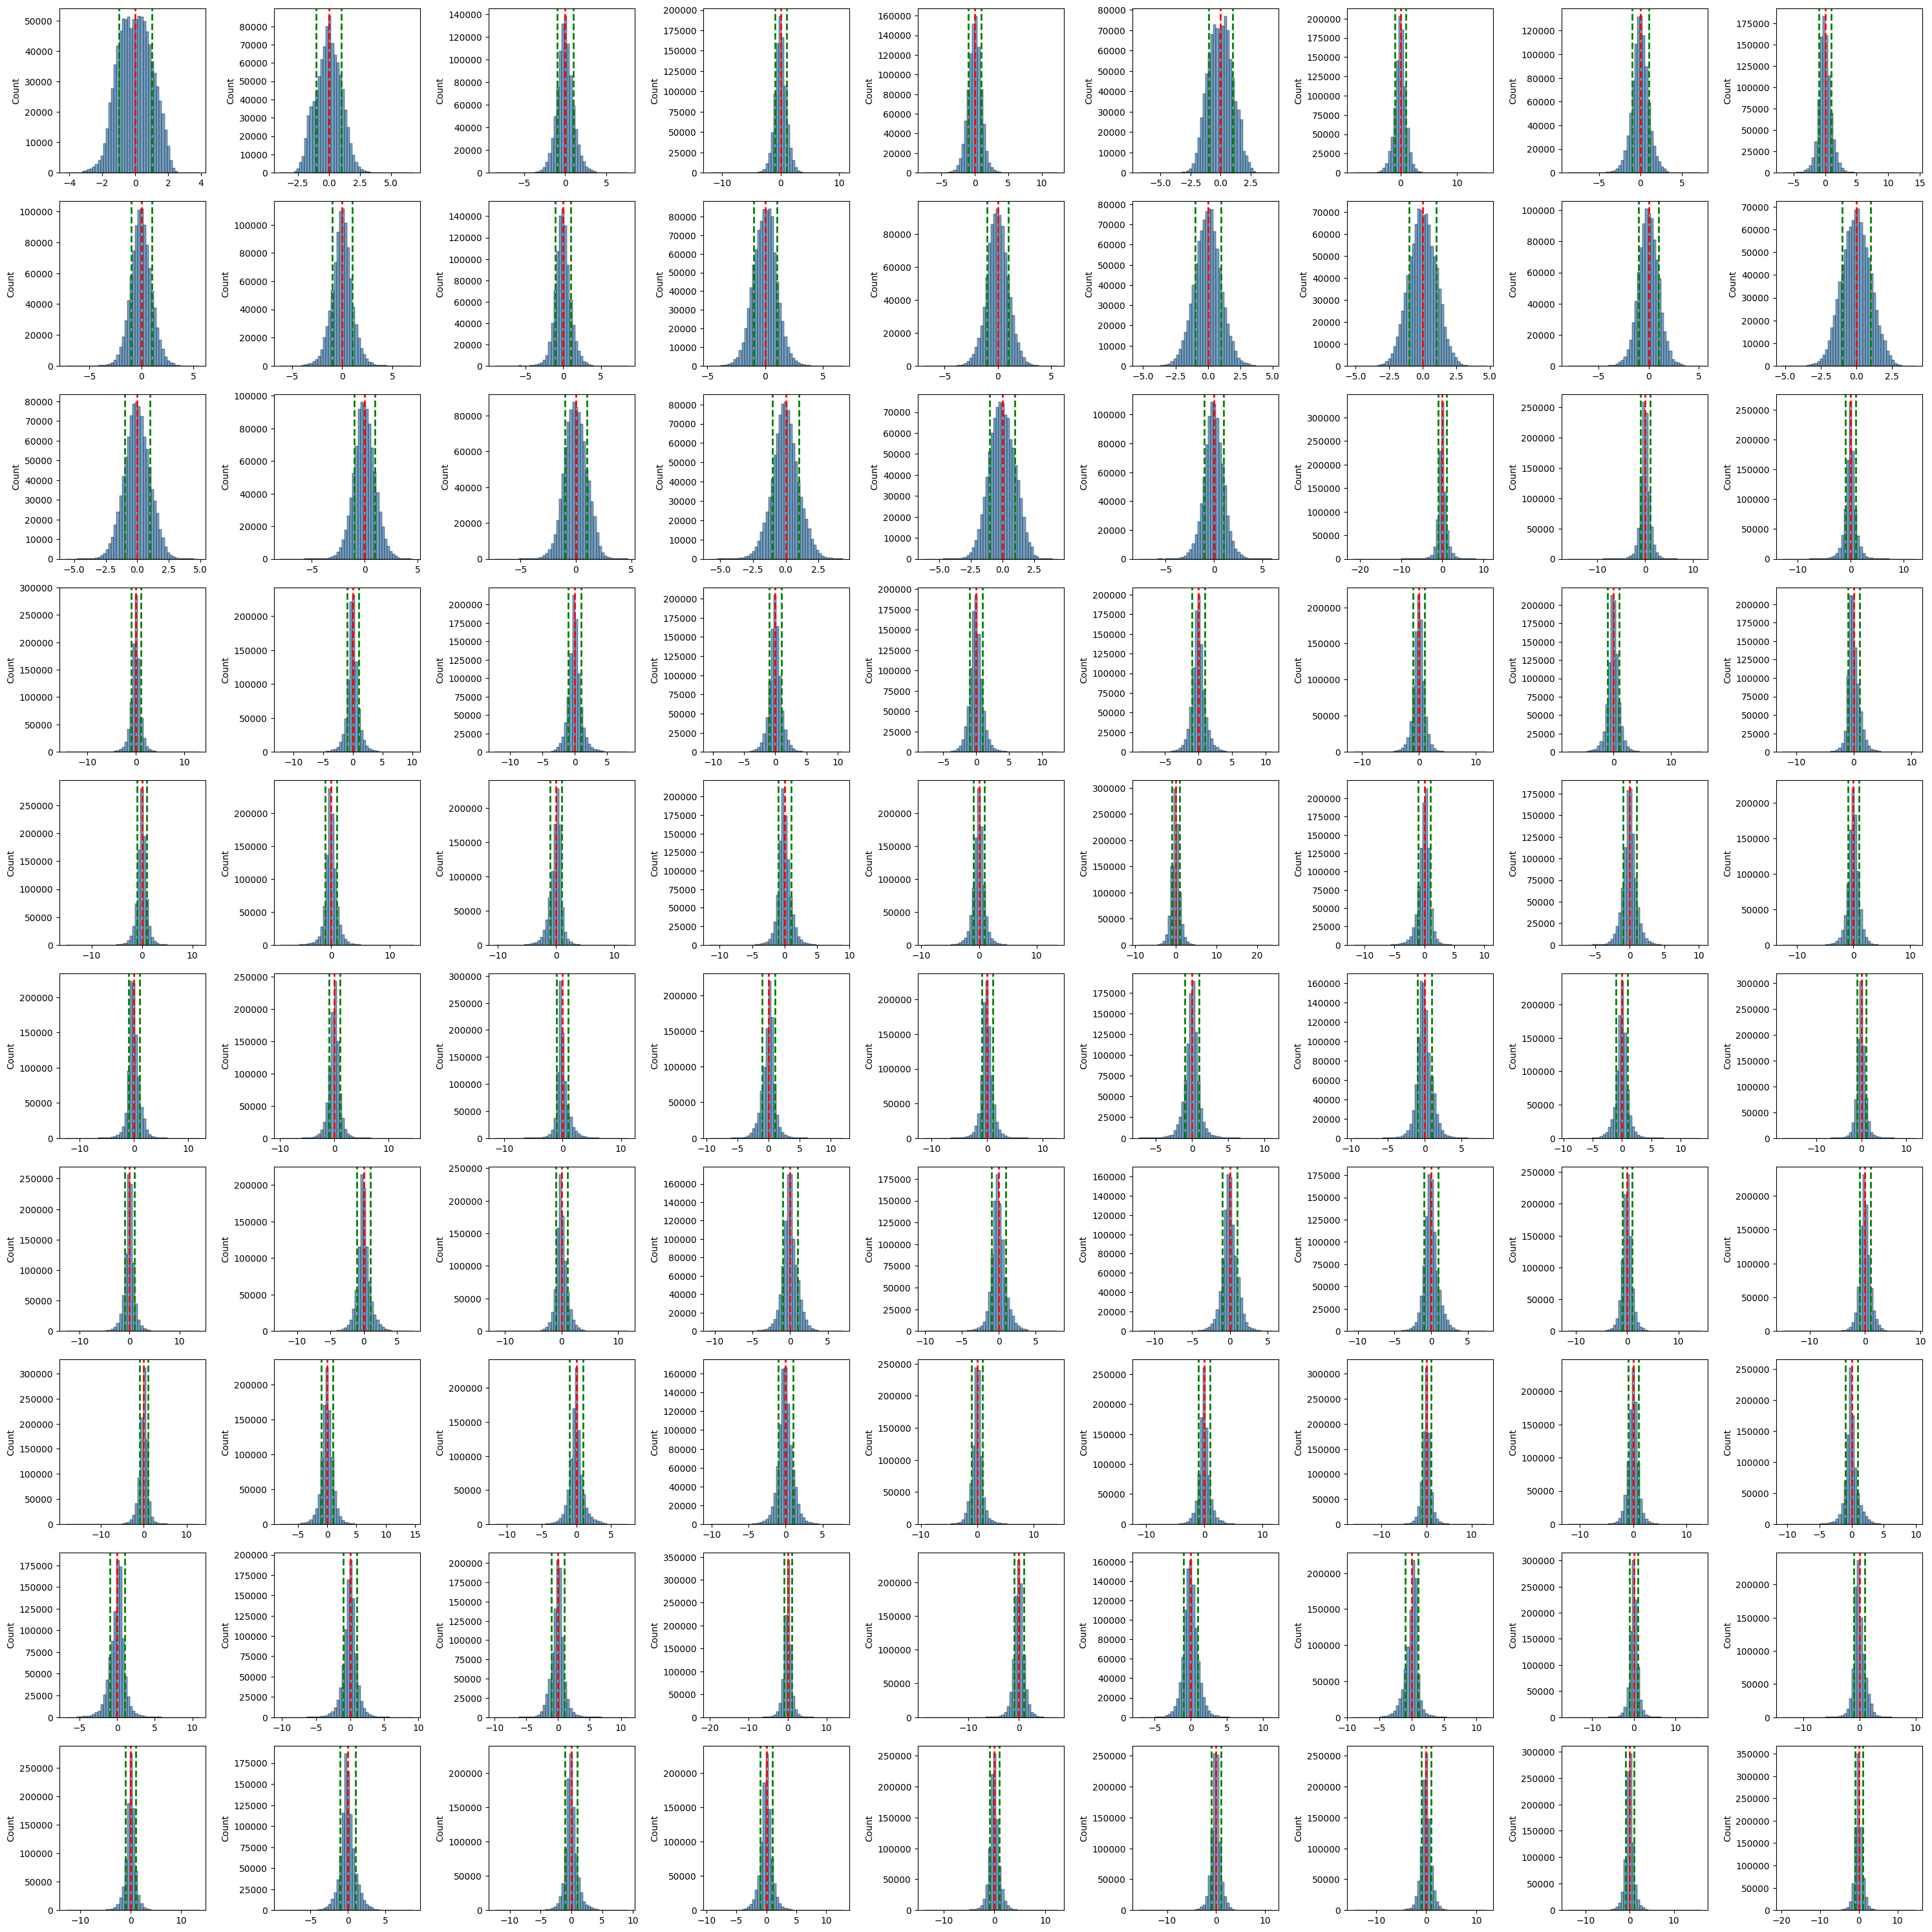

In [20]:
plot_features(X_train_final)

# Split

In [21]:
# Train valid split
def train_valid(X, y):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    train_index, valid_index = next(sss.split(X, y))

    X_valid, y_valid = X[valid_index], y[valid_index]
    X_train, y_train = X[train_index], y[train_index]

    return (X_train, X_valid), (y_train, y_valid)

(X_train_f, X_valid_f), (y_train_f, y_valid_f) = train_valid(X_train_final, y_train_final)

# Predikcija

In [23]:
lgbR = lgb.LGBMRegressor()
lgbR.fit(X_train_f,y_train_f)
y_pred = lgbR.predict(X_valid_f)
mean_squared_error(y_valid_f,y_pred)**0.5

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.267153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 836427, number of used features: 90
[LightGBM] [Info] Start training from score 1974.447741


11.108501961122995

In [ ]:
param_dist = {
    'n_estimators': [300, 600, 900],
    'learning_rate': [0.05, 0.1, 0.15],
    'num_leaves': [31, 62, 93],
    'reg_alpha': [0.05, 0.1, 0.15],
    'reg_lambda': [0.05, 0.1, 0.15],
}
lgbR = lgb.LGBMRegressor(verbose=4)
grid_search = RandomizedSearchCV(
    estimator=lgbR,
    param_distributions = param_dist,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=20,
    cv = 5,
    verbose = 3,
    refit = True
)
grid_search.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000012 seconds, init for row-wise cost 0.210373 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 929364, number of used features: 90
[LightGBM] [Info] Start training from score 1974.447756
[LightGBM] [Debug] Trained a tree with leaves = 93 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 93 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 93 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 93 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 93 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 93 and depth = 12
[LightGBM] [Debug] 

In [ ]:
lgbR = grid_search.best_estimator_

# Test

In [ ]:
X_test_f = apply_transforms(X_test, transfroms)

In [ ]:
y_pred = lgbR.predict(X_test_f)
mean_squared_error(y_test, y_pred)**0.5